In [1]:
import isx
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import stats



In [2]:
# Half-decay times: 137 ± 21 ms (jGCaMP8m)  
# supongo constante 137 ms, entonces para decaimiento exponencial:
# k = -ln(2)/137 = -0.0051 1/ms
# k = -5.1 1/s

In [3]:
pixel_sizes = [600,728] #alto x ancho # de un ejemplo de multiplane recordings
max_drift = 7 #en cada direccion
N_neurons = 5 # cuantas neuronas a simular
max_cell_diameter = 10 # max diametro de la neurona en pixeles
min_cell_diameter = 7 # min diametro de la neurona en pixeles
seconds_time = 20 #1 minuto
period_ms = 50 # tiempo entre frames en ms (20 Hz => 50 ms)
min_firerate = 1 #1 a 20 por minuto
max_firerate = 20 #1 a 20 por minuto https://elifesciences.org/articles/66048
num_samples = int(seconds_time*(1000/period_ms))
noise_level = 0.06
background_scale = 0.5
corrupted_frame_p = 0# 0.001 # no viene al caso para ustedes
ca_level = [2,4]
filename = '../seminar/videos/simulation.isxd'


In [4]:
x = np.zeros(num_samples)
y = np.zeros(num_samples)

def move_and_bounce(vprev,b):
    step = np.random.choice([1,0,-1], p=[0.01, 0.98, 0.01])
    v = vprev + step 
    if v>b:
        return b-2
    elif v<-b:
        return -b+2
    else:
        return v

for i in range(1, num_samples):
    x[i] = move_and_bounce(x[i - 1],max_drift)
    y[i] = move_and_bounce(y[i - 1],max_drift)


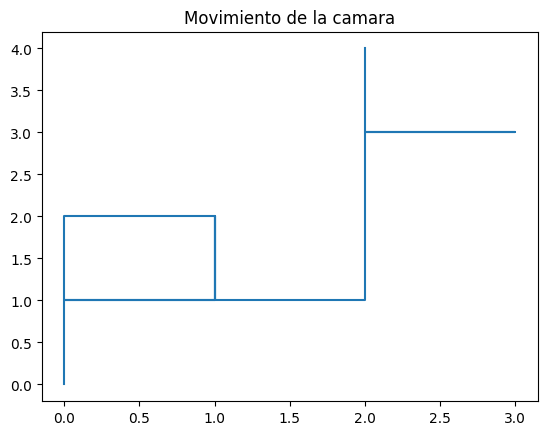

In [5]:
plt.plot(x, y)
plt.title("Movimiento de la camara")
plt.show()


In [6]:
extra_pixel_sizes = [d+max_drift*2 for d in pixel_sizes] 
border = max_cell_diameter + max_drift
dt =  period_ms/1000 #a segundos
gamma = np.exp(-5.1 * dt)
cells_diameter = np.random.randint(min_cell_diameter,max_cell_diameter,N_neurons) # de un ejemplo de multiplane recordings
cells_sigma = cells_diameter/4

In [7]:
# ojo hay chances que se pisen entre ellas, no es la mejor forma de elgir posiciones

centers = [[np.random.randint(border, x - border) for x in pixel_sizes] for i in range(N_neurons)]


In [8]:
# Defino un cellset para cada neurona
trueA = np.zeros((extra_pixel_sizes+[N_neurons]), dtype=np.float32) #area

# coloco un punto en el cellset y despues le paso un suavizado gaussiano
# cpara darle area a la celula

for i in range(N_neurons):
    tmp = np.zeros(extra_pixel_sizes)
    tmp[tuple(d // 2 for d in extra_pixel_sizes)] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, cells_sigma[i]).ravel())
    trueA[tuple(centers[i]) + (i,)] = 1
    trueA[:,:,i] = gaussian_filter(trueA[:,:,i], cells_sigma[i])/z

In [9]:

firerate =(np.random.rand(N_neurons,1)*(max_firerate-min_firerate)+min_firerate)/60 
events = np.random.rand(N_neurons, num_samples) < (firerate * period_ms/1000)
traces= events.astype(np.float32) #spikes
for i in range(1, num_samples):
    traces[:, i] += gamma * traces[:, i - 1]

cells_ca_level = np.random.rand(N_neurons,1)*(ca_level[1]-ca_level[0])+ca_level[0]
for c in range(N_neurons):
    traces[c, :] = traces[c, :]* cells_ca_level[c]+ cells_ca_level[c]


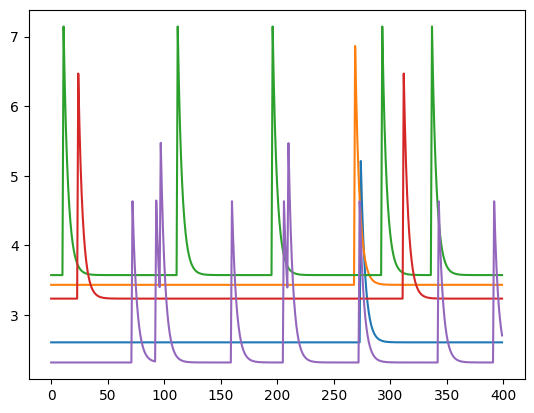

In [10]:
plt.plot(traces.T)

In [11]:
import noise

scale = 70.0
octaves = 2
persistence = 2
lacunarity = 9

background = np.zeros(extra_pixel_sizes)
for i in range(extra_pixel_sizes[0]):
    for j in range(extra_pixel_sizes[1]):
        background[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=100, 
                                    repeaty=100, 
                                    base=0)


background = (background- np.min(background))
maxb = np.max(background)

background = background / maxb * background_scale

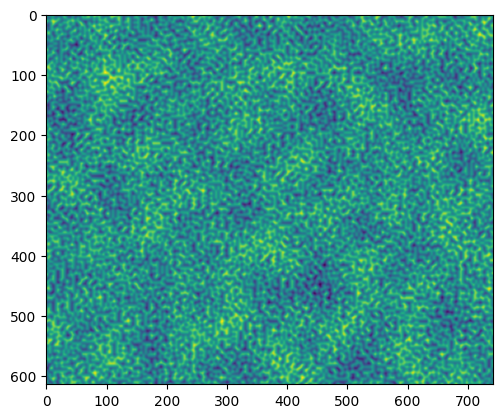

In [12]:
plt.imshow(background)

In [13]:
data = background[:,:,None]+trueA.dot(traces)

In [14]:
data_drift = np.zeros((pixel_sizes+[num_samples]),dtype=np.float32)

for i in range(num_samples):
    xd = int(max_drift + x[i])
    yd = int(max_drift + y[i])
    if np.random.random() < corrupted_frame_p:
        data_drift[:,:,i] = data.max()
    else:
        data_drift[:,:,i] = data[xd:xd+pixel_sizes[0],yd:yd+pixel_sizes[1],i]

In [15]:
data_drift = data_drift + noise_level * np.random.rand(np.prod(pixel_sizes+[num_samples])).reshape(pixel_sizes+[num_samples])

In [30]:
data_drift

array([[[0.2673972 , 0.24642572, 0.24612719, ..., 0.40391039,
         0.4208867 , 0.4158915 ],
        [0.29277067, 0.29434732, 0.27135398, ..., 0.38830006,
         0.41734988, 0.38688749],
        [0.29140695, 0.28786607, 0.29039054, ..., 0.37080132,
         0.35408239, 0.3718328 ],
        ...,
        [0.34122578, 0.33449876, 0.35293051, ..., 0.37472293,
         0.41420868, 0.41581857],
        [0.37258593, 0.39680827, 0.42062757, ..., 0.38192536,
         0.33036788, 0.34720595],
        [0.41306769, 0.4461252 , 0.42490055, ..., 0.29786619,
         0.32855786, 0.31964476]],

       [[0.28751721, 0.25585177, 0.30329929, ..., 0.44427597,
         0.45763874, 0.44623147],
        [0.29831884, 0.29722891, 0.2832707 , ..., 0.41484714,
         0.44664952, 0.46341261],
        [0.3480502 , 0.3639524 , 0.3209332 , ..., 0.39470088,
         0.41045109, 0.44141901],
        ...,
        [0.3430896 , 0.368116  , 0.36749764, ..., 0.34323886,
         0.32233149, 0.37879754],
        [0.4

In [16]:
timing = isx.Timing(num_samples=num_samples, period=isx.Duration.from_msecs(period_ms))
spacing = isx.Spacing(num_pixels=pixel_sizes)
movie = isx.Movie.write(filename, timing, spacing, np.float32)
for i in range(timing.num_samples): 
    movie.set_frame_data(i, data_drift[:,:,i].astype(np.float32)) 
movie.flush()
del movie

# Analizando registro

No corro preprocessing solo reduce datos y corrige errores del timing del registro que no esta simulado

In [17]:
import os
filename_BP = os.path.splitext(filename)[0]  +'_BP.isxd'
filename_MC = os.path.splitext(filename)[0]  +'_MC.isxd'
filename_DFF = os.path.splitext(filename)[0]  +'_dff.isxd'
filename_cellset = os.path.splitext(filename)[0]  +'_cellset.isxd'
filename_events = os.path.splitext(filename)[0]  +'_events.isxd'
translation_file = os.path.splitext(filename)[0]  +'_MC_translation.csv'
crop_rect_file = os.path.splitext(filename)[0]  +'_MC_crop_rect.csv'

In [18]:
isx.spatial_filter(input_movie_files=[filename],output_movie_files=[filename_BP],low_cutoff=0.005, high_cutoff=0.5, retain_mean=False,
        subtract_global_minimum=True)

In [19]:
isx.motion_correct(
    input_movie_files=[filename_BP],
    output_movie_files=[filename_MC],
    output_translation_files=translation_file,
    output_crop_rect_file=crop_rect_file,
    max_translation=20,
    low_bandpass_cutoff=None,
    high_bandpass_cutoff=None,
    roi=None,
    reference_segment_index=0,
    reference_frame_index=0,
    reference_file_name="",
    global_registration_weight=1.0,
    preserve_input_dimensions=False
)

In [20]:
isx.dff(input_movie_files=filename_MC,output_movie_files=filename_DFF,f0_type= "mean")

In [21]:
filename_projDFF = os.path.splitext(filename)[0]  +'_projDFF.isxd'
isx.project_movie(filename_DFF,filename_projDFF, stat_type='max')

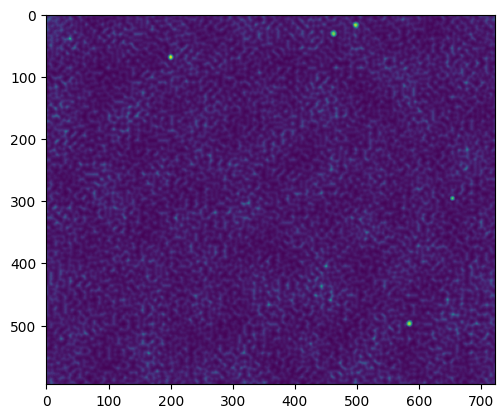

In [22]:

img=isx.Image.read(filename_projDFF).get_data()

plt.imshow(img)
plt.show()


In [23]:
isx.pca_ica(
    input_movie_files=[filename_DFF],
    output_cell_set_files=[filename_cellset],
    num_pcs=15,
    num_ics=7,
    unmix_type="spatial",
    ica_temporal_weight=0,
    max_iterations=1000,
    convergence_threshold=1e-5,
    block_size=8000,
    auto_estimate_num_ics=False,
    average_cell_diameter=9
)

True

In [24]:
isx.event_detection(
    input_cell_set_files=filename_cellset,
    output_event_set_files=filename_events,
    threshold=4,
    tau=0.095,
    event_time_ref="maximum",
    ignore_negative_transients=True,
    accepted_cells_only=False
)

In [25]:
import matplotlib.cm as cm
def overlay_cellmaps(background_image, cellmaps, traces = [], timestamps=[], indices = []):
     """
    Plot contours of cellmaps over a background image and corresponding traces if indices is specified 
    The function behaves differently depending on the input of indices 
    Usage: 
    overlay_cellmaps(background_image, cellmaps):
        Will overlay the contours of the cellmaps over the background image without any traces 
    overlay_cellmaps(background_images, cellmaps, traces, indices = List)
        Will overlay the contours of a the cells specified by indices (into cellmaps) in a list with corresponding traces   
    
    An example use: 
    # read in max projection file (.isxd)
    max_proj = isx.Image.read(max_proj_file).get_data()
    # get out cellset data from cnmfefile (.isxd)
    accepted_traces, accepted_cellmap, accepted_timestamps = extract_cell(cnmfefile, ['accepted'], True) 
    # pick out random cells
    n_random_cells = 10
    random_indices = random.sample(range(0, accepted_traces.shape[1]), n_random_cells)
    # plot overlay
    f, axs = overlay_cellmaps(max_proj, accepted_cellmap, accepted_traces, accepted_timestamps, random_indices)
    # add title for subplot 1
    axs[0].set_title('cnmfe contour map for sample cells' );
    # add title for subplot 2
    axs[1].set_title('sample CNMFe Z-scored cell traces' ); 
    plt.show()

    
    Inputs :
        background_image    : background image (e.g. max projection, numpy array) 
        cellmaps            : cell maps extracted from cellset (numpy array, see function extract_cells)
        traces              : traces extracted from cellset (numpy array, see function extract_cells)
        timestamps          : timestamps extracted from cellset (numpy array, see function extract_cells)
        indices             : can be : [] or a List
                              if indices= [],  overlays all the cell contours in cellmap without traces
                              if indices= List, overlays cells specified by indices in the List with corresponding traces   
    Returns:
        figure handle : handle to the figure (can use this to e.g.  save plot) 
        axis handle   : handle to the axis (can use this to e.g. modify plot aesthetics)


    """

     if len(indices) == 0:
        # intialize figure 
        f = plt.figure(figsize=(5, 5))
        # plot background image
        plt.imshow(background_image, 'gray')
        # plot contours of the cellmaps
        for i in range(cellmaps.shape[2]):
            plt.contour(cellmaps[:, :, i], colors='m', linewidths=1, alpha=0.3)
       
        # get out axes and set axes parameters
        axs = f.axes
        axs[0].set_xticks([])
        axs[0].set_yticks([])
     else:
        # picking n colors and making a dictionary
        n_cells = len(indices)
        color_dict = {}
        color = iter(cm.rainbow(np.linspace(0, 1, n_cells)))
        for i in indices :
            color_dict[i] = next(color)

        # intialize plot and axes
        f, axs = plt.subplots(1,2, figsize=(20,10)) # initialize subplot
        # intialize spacing for traces 
        offset = 10 # for plotting traces


        # first subplot: max_dff to overlay cell contours
        axs[0].imshow(background_image, 'gray')
        # plot each cell
        for i in indices:
            offset -= 12 # separate the y axis for each trace
            # first subplot: plot contour
            axs[0].contour(cellmaps[:, :, i], alpha=0.3, colors=matplotlib.colors.to_hex(color_dict[i]))
            # second subplot: plot trace
            axs[1].plot(timestamps, traces[:, i]-offset,c=color_dict[i])
           
        # adjust axes properties 
        # first subplot
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        # second subplot     
        axs[1].set_xlabel('Time since Start (s)')
        axs[1].set_yticks([])
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
    
        
     return f, axs

In [26]:
# define a function to extract calcium traces,
# cell maps and timestamps from a cellset .isxd file

def extract_cell(dataset, status_list=['accepted', 'rejected', 'undecided'], Zscore=False):
    """
    Extract calcium traces, cellmaps and timestamps
        and filtered by cell accepted/rejected/undecided status
    Parameters:
        dataset: pca-ica or cnmfe dataset
        status_list: status filter, default setting includes all categories
        Zscore: optional
                whether to convert traces to Zscore scale
                Default set to False to not convert
    Returns:
        cell_trace_all: cell by frame numpy matrix
                        trace series from all cells
                        Y axis scale is dependent on input cellset or Zscore setting
        cell_image_all: binarized cell maps from all cells
                        H pixels x W pixels x cell number.
        timestamps: timestamp extracted from the .isxd movie

    """

    cell_set = isx.CellSet.read(dataset)   # load the dataset
    num_cells = cell_set.num_cells  # retrieve cell number
    # retrieve the timestamps
    timestamps = [offset.secs_float for offset
                  in cell_set.timing.get_offsets_since_start()]
    total_frame_num = cell_set.timing.num_samples
    # initiate image holder and trace holder
    image_size = cell_set.get_cell_image_data(0).astype(np.float64)

    cell_image_all = np.empty(shape=(image_size.shape[0],
                                     image_size.shape[1], num_cells))
    cell_trace_all = np.empty(shape=(total_frame_num, num_cells))

    # set cell filter to label cells that match the input index list
    # initiation with false boolean
    id_filter = [False for i in range(num_cells)]

    # load cell images and traces into holder when the status matches
    for cell in range(num_cells):
        if (cell_set.get_cell_status(cell) in status_list):
            id_filter[cell] = True
        cell_image = cell_set.get_cell_image_data(cell).astype(np.float64)
        # threshold the cell image to get binarized cellmap
        cell_image = cell_image > (0.9 * np.max(cell_image))
        # append cell maps
        cell_image_all[:, :, cell] = cell_image

        # retrieve and append cell traces
        cell_trace = cell_set.get_cell_trace_data(cell)
        cell_trace_all[:, cell] = cell_trace

    # Optional: convert to Zscore
    if Zscore:
        cell_trace_all = stats.zscore(cell_trace_all)

    return (cell_trace_all[:, id_filter], cell_image_all[:, :, id_filter], timestamps)

In [27]:
accepted_traces, accepted_cellmap, accepted_timestamps = extract_cell(filename_cellset,Zscore=True)

In [28]:
import matplotlib

(<Figure size 2000x1000 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time since Start (s)'>], dtype=object))

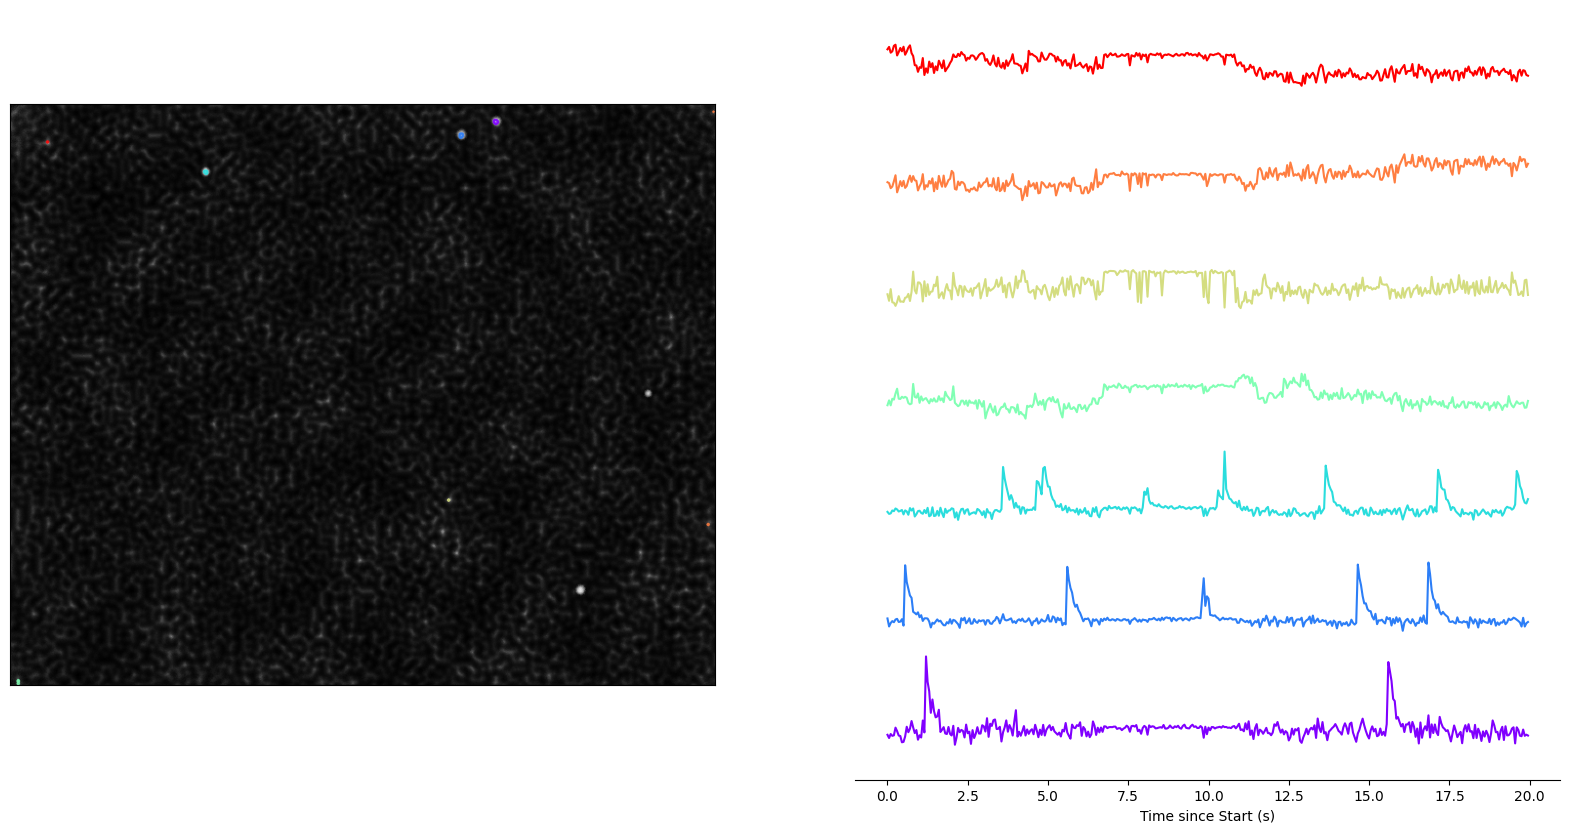

In [29]:
overlay_cellmaps(
    background_image=img,
    cellmaps=accepted_cellmap,traces=accepted_traces, 
    timestamps=accepted_timestamps,indices=[0,1,2,3,4,5,6]
)